In [3]:
import torch
import torch.nn as nn
from performer_pytorch import Performer
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np


/home/walt/miniconda3/envs/esm2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
B = 2       # 2 samples
G = 50      # 50 genes
DIM = 32    # use smaller dim for visualization
x = torch.rand(B, G) * 5  # fake log(TPM+1)


In [5]:
class REE(nn.Module):
    def __init__(self, dim=DIM):
        super().__init__()
        half = dim // 2
        i = torch.arange(1, half+1)
        self.theta = (100 ** (2 * i / dim)).float()

    def forward(self, x):
        B,G = x.shape
        angles = x.unsqueeze(-1) * self.theta  # [B,G,dim/2]
        return torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)


In [6]:
ree = REE(DIM)
ree_out = ree(x)
ree_out.shape


torch.Size([2, 50, 32])

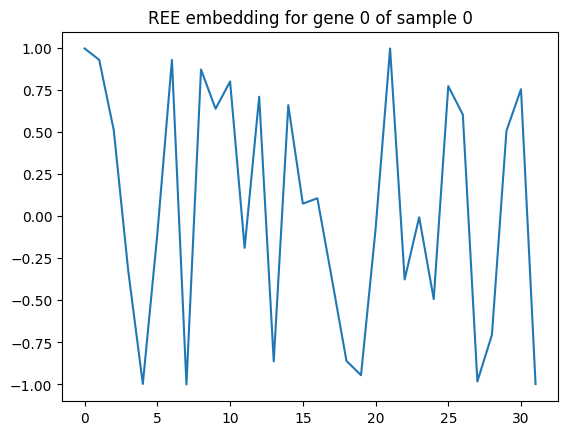

In [7]:
plt.plot(ree_out[0,0].detach().numpy())
plt.title("REE embedding for gene 0 of sample 0")
plt.show()


In [8]:
gene_emb = nn.Parameter(torch.randn(G, DIM))

proj = nn.Sequential(
    nn.Linear(DIM, DIM),
    nn.ReLU(),
    nn.Linear(DIM, DIM)
)

esm_proj = proj(gene_emb)        # [G,DIM]
esm_proj = esm_proj.unsqueeze(0) # → [1,G,DIM] for broadcasting


In [9]:
esm_proj.shape


torch.Size([1, 50, 32])

In [10]:
sample_context = torch.randn(B, DIM)
sample_context = sample_context.unsqueeze(1)  # [B,1,DIM]


In [11]:
sample_proj = sample_context.expand(B, G, DIM)


In [12]:
tokens = ree_out + esm_proj + sample_proj
tokens.shape


torch.Size([2, 50, 32])

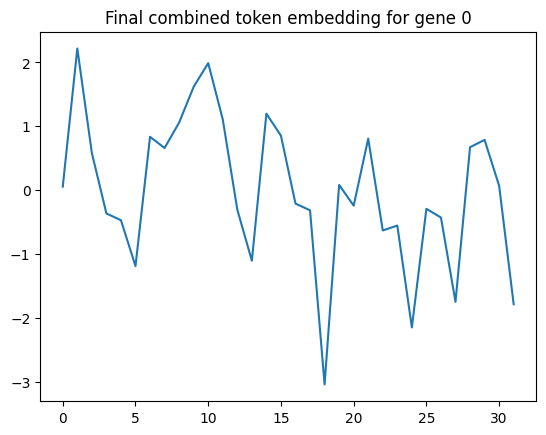

In [13]:
plt.plot(tokens[0,0].detach().numpy())
plt.title("Final combined token embedding for gene 0")
plt.show()


In [14]:
# simple chain graph: 0-1-2-3-...-49
edges = torch.tensor([
    [i for i in range(G-1) for _ in (0,1)],
    [i+1 if j%2==0 else i for i in range(G-1) for j in (0,1)]
], dtype=torch.long)

# Flatten tokens → [B*G, dim]
flat_tokens = tokens.reshape(B*G, DIM)

gcn = GCNConv(DIM, DIM)
gcn_out = gcn(flat_tokens, edges)
gcn_out = gcn_out.reshape(B, G, DIM)


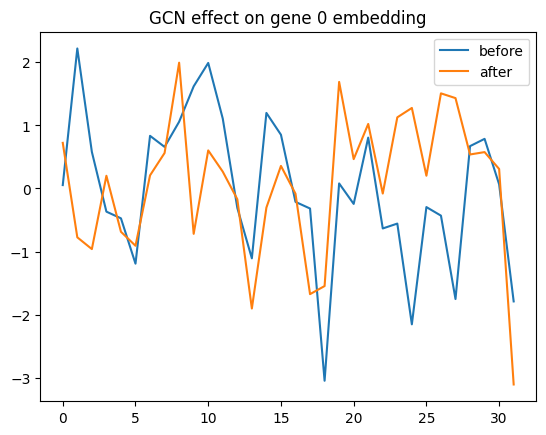

In [15]:
plt.plot(tokens[0,0].detach(), label='before')
plt.plot(gcn_out[0,0].detach(), label='after')
plt.legend()
plt.title("GCN effect on gene 0 embedding")
plt.show()


In [16]:
performer = Performer(
    dim=DIM,
    depth=1,
    heads=4,
    dim_head=DIM//4
)

perf_out = performer(gcn_out)
perf_out.shape


torch.Size([2, 50, 32])

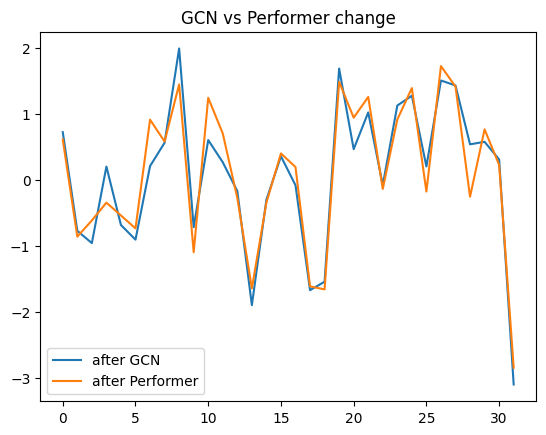

In [17]:
plt.plot(gcn_out[0,0].detach(), label='after GCN')
plt.plot(perf_out[0,0].detach(), label='after Performer')
plt.legend()
plt.title("GCN vs Performer change")
plt.show()


In [18]:
out_head = nn.Linear(DIM, 1)
pred = out_head(perf_out)  # [B,G,1]
pred.shape


torch.Size([2, 50, 1])

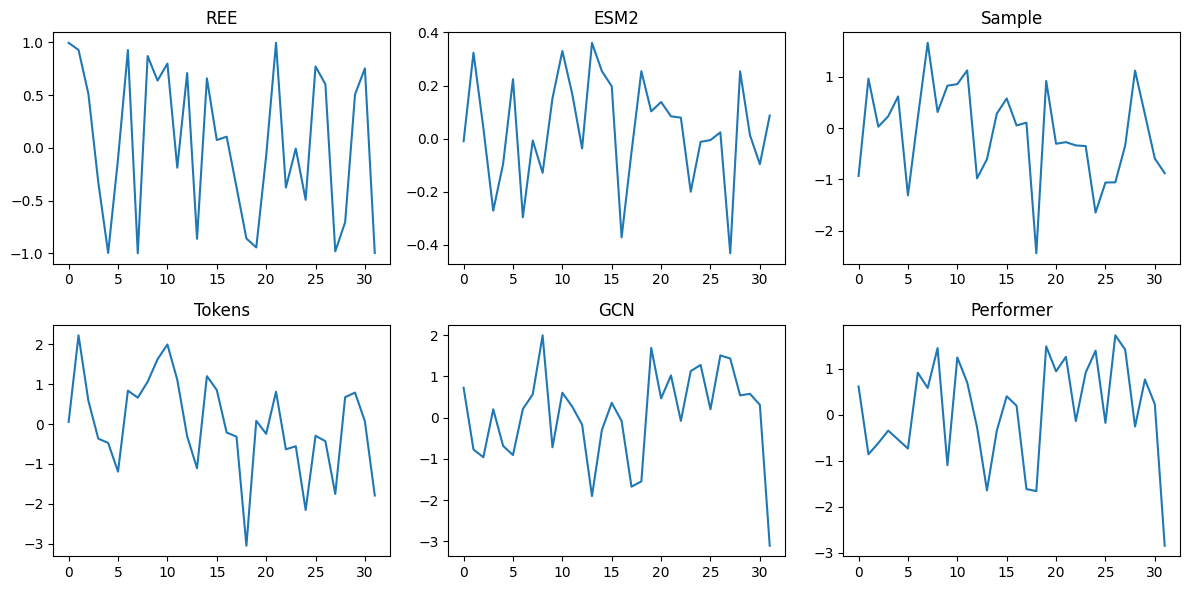

In [19]:
steps = {
    "REE": ree_out[0,0].detach(),
    "ESM2": esm_proj[0,0].detach(),
    "Sample": sample_proj[0,0].detach(),
    "Tokens": tokens[0,0].detach(),
    "GCN": gcn_out[0,0].detach(),
    "Performer": perf_out[0,0].detach(),
}

plt.figure(figsize=(12,6))
for i, (name, vec) in enumerate(steps.items(), 1):
    plt.subplot(2,3,i)
    plt.plot(vec)
    plt.title(name)

plt.tight_layout()
plt.show()
